# Stable Diffusion Flowers

This notebook demonstrates the concept of Stable Diffusion. It uses the pre-trained model from this repository for inference.
(Training the model is not part of this notebook. For training, please refer to the `sd_train.py` script at the root of this repository.)

## Table of Contents

- [Imports](#imports) – Load the required libraries and modules.
- [Dataset](#dataset) – Load the dataset and prepare it for training.
- [Scheduler](#scheduler) – Set up the scheduler for the diffusion process.
- [Model](#model) – Load the pre-trained Stable Diffusion model.
- [Denoising](#denoising) – Perform the denoising process using the model.
- [Inference](#inference) – Generate images from the model using the denoising process.
- [Getting Creative](#getting-creative) – Using the model to generate images based on a simple drawing.

## Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.swa_utils import AveragedModel
from torchvision.datasets import Flowers102

from lib.unet import UNet  # self-defined UNet model

# Define the device to do the computation on
# If a GPU is available, use it; otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset

We will use the `Flowers102` dataset, which contains 102 categories of flowers. The categories are not important for us, but the images are.
Before we load the dataset, we need to define the `transform` function, which will be used to preprocess the images. We want the following transformations:

- PIL to Tensor: Convert the image to a PyTorch tensor.
- Resize: Resize the image so that the smallest side is 128 pixels.
- CenterCrop: Crop the image to 128x128 pixels so that the image is square.
- Convert to float: Convert the image to a float tensor.
- Normalize: Normalize the image to have a mean of 0 and a variance of 1.

Moreover, we will define `denomalize` and `normalize` functions to convert the image back and forth between the original and normalized form. This is useful for displaying the images after denoising.
This means whenever we want to do the denoising process, we will normalize the image so that it has about 0 mean and 1 variance. When we want to display the image, we will denormalize it so that it has normal pixel values between 0.0 and 1.0.

Thus an image in the dataset will now be a tensor of shape `(3, 128, 128)` with mean pixel values of 0.0 and variance of 1.0.

In [2]:
# calculated over the whole dataset
mean = [0.4750, 0.3940, 0.3079]
std = [0.2218, 0.2075, 0.2036]

# transform to be applied to the images in the dataset
# the transform is applied to the images when they are loaded from disk
transform = transforms.Compose([
    transforms.PILToTensor(),  # convert PIL image to PyTorch tensor
    transforms.Resize(128),  # resize the image to have a minimum size of 128x128 pixels
    transforms.CenterCrop(128),  # crop the image to 128x128 pixels around the center
    transforms.ConvertImageDtype(torch.float32),  # convert the image to float32
    transforms.Normalize(mean, std)  # normalize so that data has zero mean and unit variance
])

# load the dataset
test_data = Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)

# function to reverse the normalization applied to the images
# this is used to display the images in their original form
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    tensor = tensor * std + mean  # the transform applies this in reverse
    return tensor.clamp(0, 1)

# function to apply normalization to the images
# this is used to prepare images outside the dataset for inference
def normalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    tensor = (tensor - mean) / std
    return tensor

Let's display a few images from the dataset to see what we are working with. We will sample images at random from the dataset. 

We must not forget to denormalize the images before displaying them. When calling the `denormalize` function with the image, we need to add a batch dimension to the image tensor. This is because the `denormalize` function expects a batch of images, not a single image. We can do this by using `unsqueeze(0)` on the image tensor. This will add a new dimension at index 0, making the shape of the tensor `(1, 3, 128, 128)`. 

The `denormalize` function will then return a tensor of shape `(1, 3, 128, 128)`. We can then use `squeeze(0)` to remove the batch dimension, making the shape of the tensor `(3, 128, 128)`.

Lastly, matplotlib expects the image to be in the format `(H, W, C)`, so we need to permute the dimensions of the tensor to get the shape `(128, 128, 3)` before displaying it. We can do this by using `permute(1, 2, 0)` on the image tensor. This will rearrange the dimensions of the tensor to the desired format.

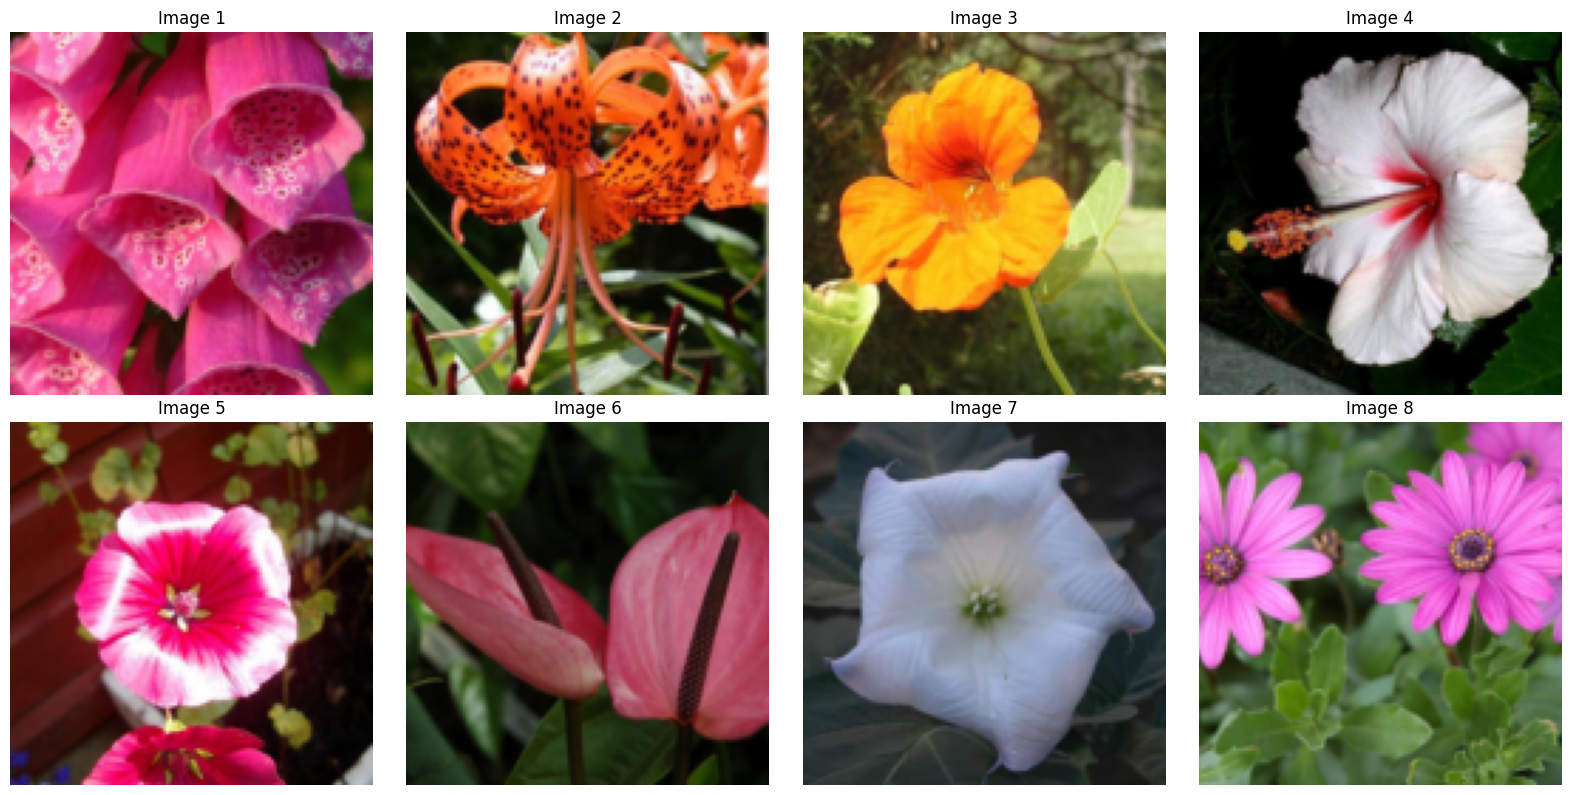

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    sample_img, _ = test_data[sample_idx] # image, label (label is not used here)
    sample_img = denormalize(sample_img.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(sample_img.permute(1, 2, 0))
    ax.set_title(f"Image {i + 1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Scheduler

A scheduler is a key component of the diffusion process. It defines how the noise is added to the images during the forward diffusion process and how it is removed during the reverse diffusion process. The scheduler is responsible for controlling the noise schedule, which determines how much noise is added at each step of the diffusion process.

Mathematically speaking, suppose we have an image $x_0$ we want to corrupt over a large number of steps $T$, so that eventually we get a pure noise image $x_T$. The forward diffusion process is defined as follows:

$$ x_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon $$

where $x_t$ is the image at time step $t$, $x_{t-1}$ is the image at the previous time step, $\beta_t$ is the noise schedule, and $\epsilon$ is a standard Gaussian noise with zero mean and unit variance.

Because we normalized the images, we can also assume that $x_{t-1}$ has zero mean and unit variance. This means that $\sqrt{1 - \beta_t} x_{t-1}$ will have variance $1 - \beta_t$ and $\sqrt{\beta_t} \epsilon$ will have variance $\beta_t$, using the property of variance $Var(aX) = a² Var(X)$, where $a$ is a constant and $X$ is a random variable.

This means using the property of variance Var(X + Y) = Var(X) + Var(Y) for independent random variables X and Y, we can say that the variance of $x_t$ is:

$$ Var(x_t) = Var(\sqrt{1 - \beta_t} x_{t-1}) + Var(\sqrt{\beta_t} \epsilon) = (1 - \beta_t) + \beta_t = 1 $$

That way we proved by induction that all $x_t$, including the final image $x_T$, have approximately zero mean and unit variance.

This means our forward noise process is a Markov chain, where each image $x_t$ is generated from the previous image $x_{t-1}$ by adding noise according to the noise schedule $\beta_t$. It is defined by the following equations:

$$ q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I) $$

### Reparameterization Trick

This is a common technique to instandtly jump to any noise level of the image $x_t$ from the original image $x_0$ without having to go through all the intermediate steps.

If we define $\alpha_t = 1 - \beta_t$, and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$, we can rewrite the forward diffusion process as:

$$ x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} \epsilon $$
$$ x_t = \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \epsilon $$
$$ x_t = \sqrt{\alpha_t \alpha_{t-1} \alpha_{t-2}} x_{t-3} + \sqrt{1 - \alpha_t \alpha_{t-1} \alpha_{t-2}} \epsilon $$
$$ x_t = ... $$
$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$
    
Thus, we can also write the forward noise process as:

$$ q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I) $$

### Diffusion Schedules

We are free to choose different noise schedules $\beta_t$ at each timestep. How $\beta_t$ and $\alpha_t$ change over time is called the diffusion schedule. We will use a cosine schedule as it is a well-known schedule that works well in practice.

This means that the equation for getting $x_t$ from $x_0$ is: $x_t = cos(\frac{t}{T} \pi / 2) x_0 + sin(\frac{t}{T} \pi / 2) \epsilon$

This will work since: $cos²(x) + sin²(x) = 1$.

with this our $\bar{\alpha}_t$ is now: $\bar{\alpha}_t = cos²(\frac{t}{T} \pi / 2)$

For simplicity, we will still keep using the linear schedule for the following equations, even though we will use the cosine schedule in the code.

In [4]:
def cosine_diffusion_schedule(diffusion_times, device):
    # We will use a small offset to prevent noising steps becoming too small
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.acos(torch.tensor(max_signal_rate, device=device))
    end_angle = torch.acos(torch.tensor(min_signal_rate, device=device))

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

Now we define `T` as the number of diffusion steps. Remember this is the number of steps we will take to go from the original image $x_0$ to the final image $x_T$. In training, there are usually about 1000 steps, but we can use a smaller number of steps for inference.

In [5]:
T = 10  # timestep at which the image is complete noise

Let's plot the diffusion schedule. The plotted values need to be squared to get the actual noise schedule. Notice how the signal and noise rate add up to 1.0. The signal rate is the amount of the original image we keep, and the noise rate is the amount of noise we add. The sum of both is always 1.0.

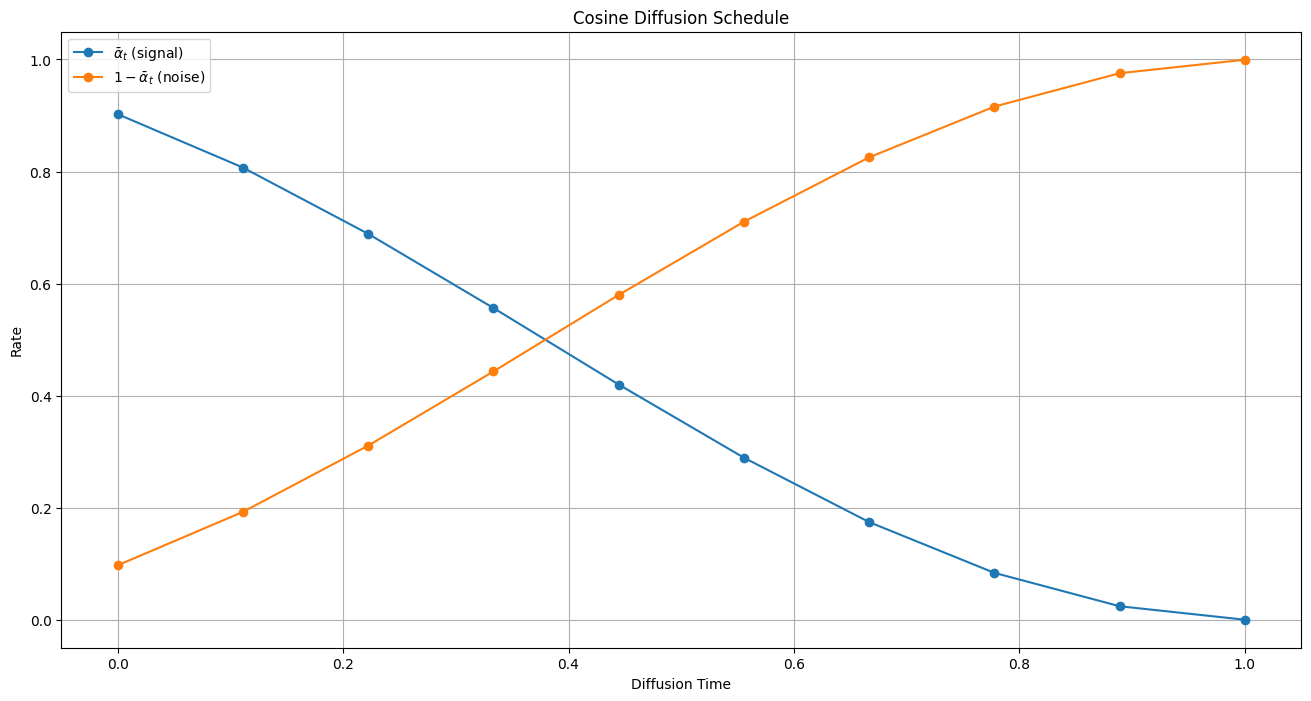

In [6]:
t_array = torch.linspace(0, 1, T)
noise_rates, signal_rates = cosine_diffusion_schedule(t_array, device="cpu")
plt.figure(figsize=(16, 8))
plt.plot(t_array.numpy(), signal_rates.square().numpy(), label=r'$\bar\alpha_t$ (signal)', marker='o')
plt.plot(t_array.numpy(), noise_rates.square().numpy(), label=r'$1-\bar\alpha_t$ (noise)', marker='o')
plt.title('Cosine Diffusion Schedule')
plt.xlabel('Diffusion Time')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

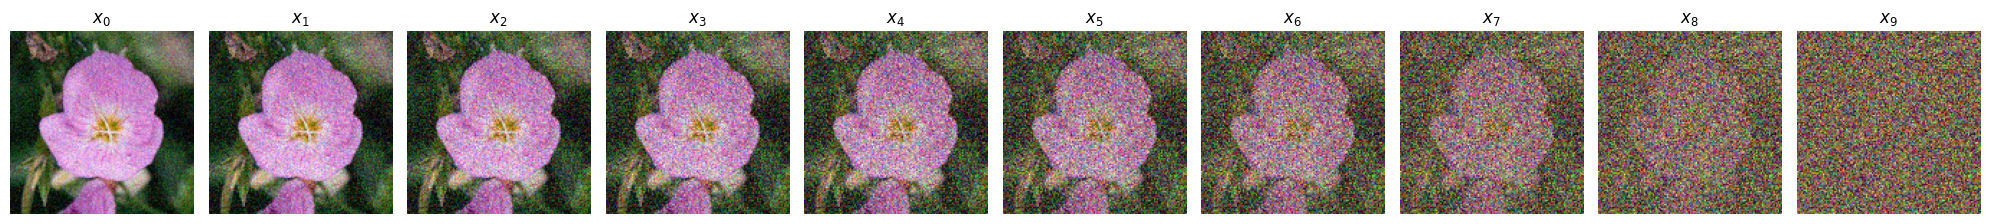

In [7]:
x_0, _ = test_data[0]
x_t_list = []  # noisy images
gaussian_noise = torch.randn_like(x_0)  # noise with zero mean and unit variance with the same shape as image

# Create the noisy images
for t in range(len(t_array)):
    x_t = signal_rates[t] * x_0 + noise_rates[t] * gaussian_noise
    x_t_list.append(x_t)

fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(axes.flatten()):
    x_t = x_t_list[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0))
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

## Model

In [8]:
image_shape = (3, 128, 128)
model = UNet(
    in_shape=image_shape,
    out_shape=image_shape,
    features=[64, 128, 256, 512, 1024],
    embedding_dim=64
).to(device)
ema_model = AveragedModel(
    model,
    multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.999),
    device=device
)
ema_model.load_state_dict(torch.load("model.pt", map_location=device))
ema_model.eval()
print("Model loaded successfully")

Model loaded successfully


## Denoising

In [9]:
def denoise(model, noisy_images, noise_rates, signal_rates):
    predicted_noises = model(noisy_images, noise_rates ** 2)
    predicted_images = (noisy_images - noise_rates * predicted_noises) / signal_rates
    return predicted_noises, predicted_images

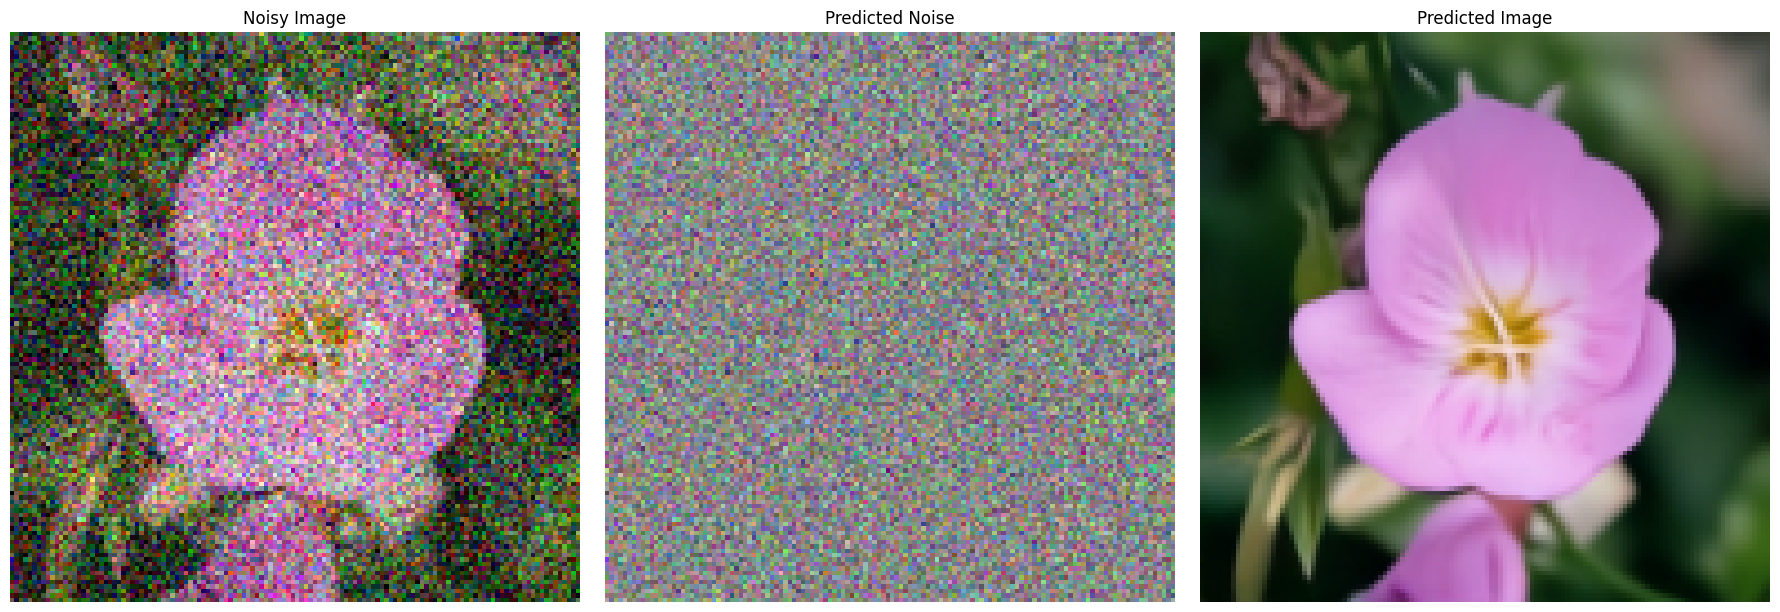

In [10]:
timestep = 4
x_t = x_t_list[timestep].unsqueeze(0).to(device)  # add a batch dimension (1, 3, 128, 128)

with torch.no_grad():
    pred_noise, pred_image = denoise(ema_model, x_t, noise_rates[timestep], signal_rates[timestep])

noisy_image = denormalize(x_t, mean, std)
pred_image = denormalize(pred_image, mean, std)

# Normalize the predicted noise to [0, 1] for visualization
pred_noise_img = pred_noise.squeeze(0)
pred_noise_min = pred_noise_img.min()
pred_noise_max = pred_noise_img.max()
pred_noise_img = (pred_noise_img - pred_noise_min) / (pred_noise_max - pred_noise_min)

# Create a figure with 3 subplots for the noisy image, predicted noise, and predicted image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Noisy Image")
axes[0].axis("off")

axes[1].imshow(pred_noise_img.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Predicted Noise")
axes[1].axis("off")

axes[2].imshow(pred_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[2].set_title("Predicted Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## Inference

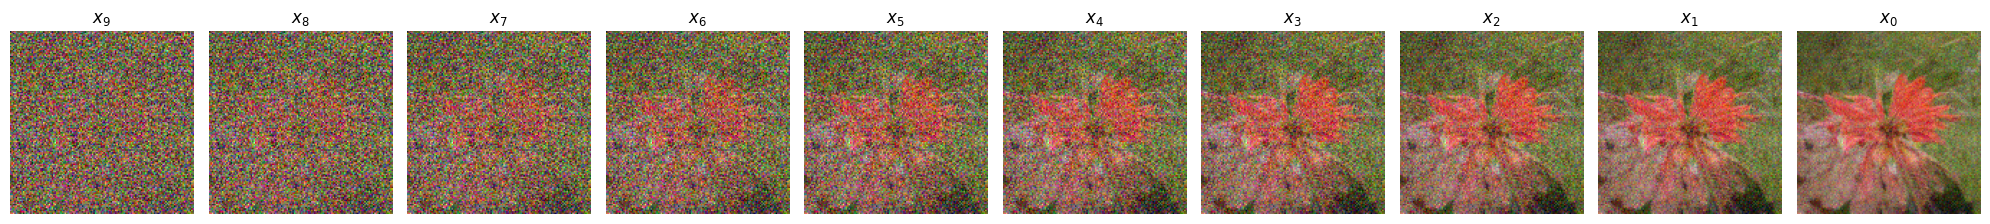

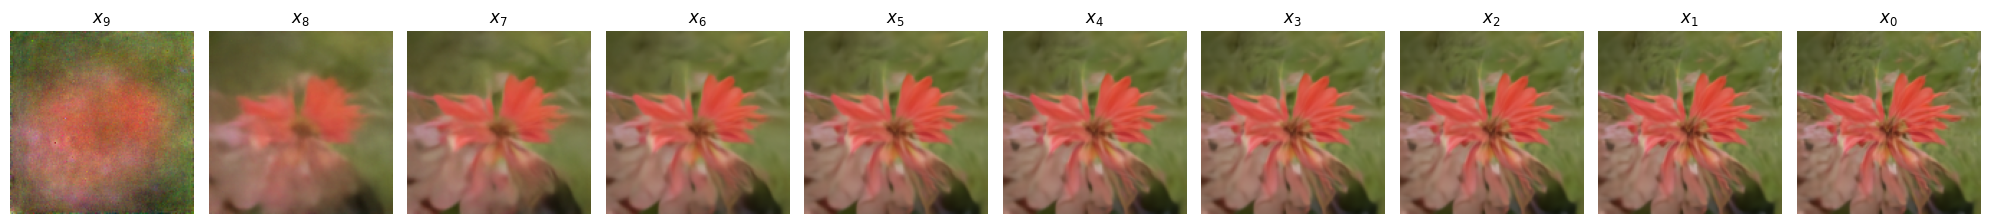

In [11]:
gaussian_noise = torch.randn(1, *image_shape, device=device)  # x_T but pure noise
step_size = 1.0 / T

x_t_reverse_diffusion_list = []
predicted_images = []

next_x_t = gaussian_noise
for step in range(T):
    x_t = next_x_t

    t = torch.ones((1, 1, 1, 1), device=device) - step * step_size
    noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
    with torch.no_grad():
        pred_noise, pred_image = denoise(ema_model, x_t, noise_rate, signal_rate)

    next_t = t - step_size
    next_noise_rate, next_signal_rate = cosine_diffusion_schedule(next_t, device)
    next_x_t = next_signal_rate * pred_image + next_noise_rate * pred_noise

    x_t_reverse_diffusion_list.insert(0, next_x_t.squeeze(0))
    predicted_images.insert(0, pred_image.squeeze(0))

# display the diffusion steps
fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(reversed(axes.flatten())):
    x_t = x_t_reverse_diffusion_list[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0).cpu().numpy())
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

# display the predicted images
fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(reversed(axes.flatten())):
    x_t = predicted_images[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0).cpu().numpy())
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

## Getting Creative

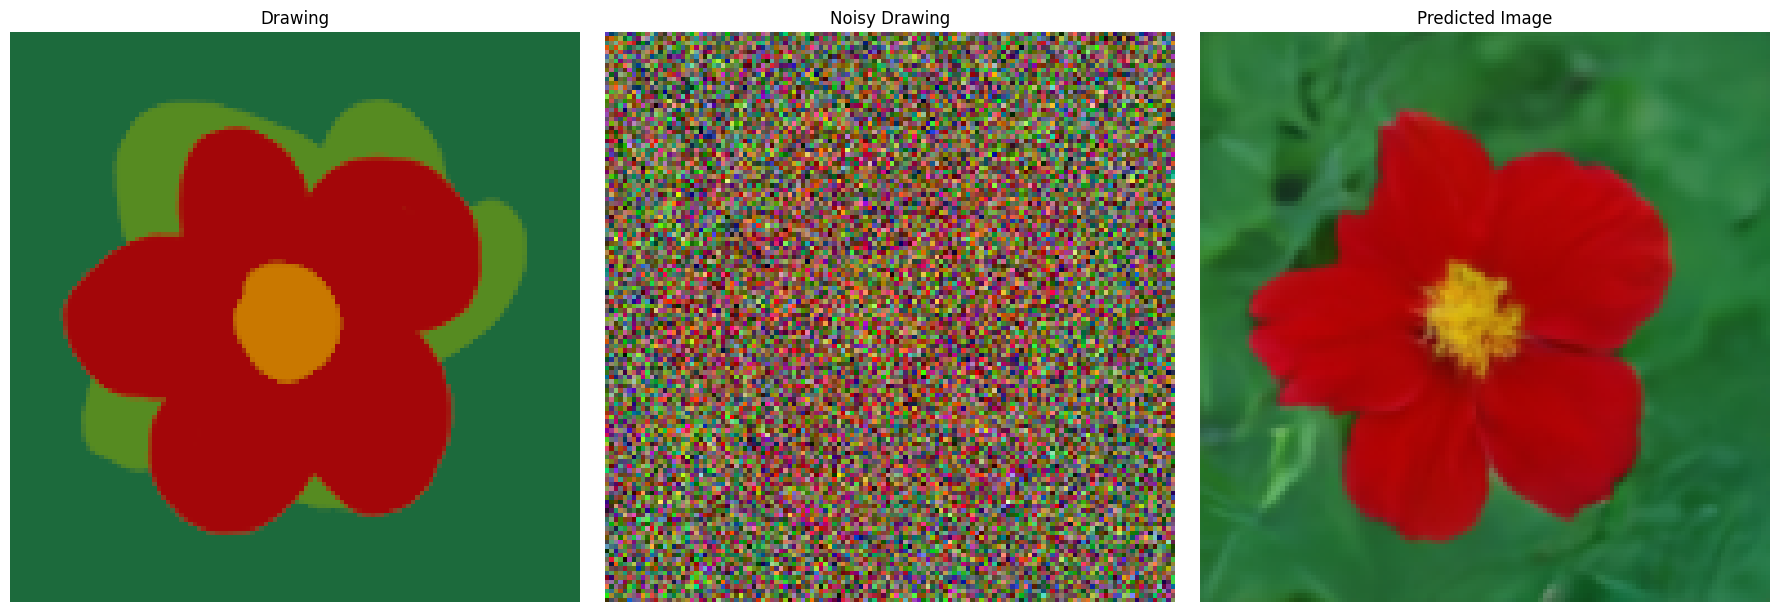

In [12]:
strength = 0.9
step_size = strength / T

# load drawing
drawing = torchvision.io.read_image("docs/drawing.png").float() / 255.0

# add batch dimension and send to device
drawing = drawing.unsqueeze(0).to(device)

# normalize the drawing
drawing = normalize(drawing, mean, std)

# apply the noise
gaussian_noise = torch.randn(1, *image_shape, device=device)
t = torch.full((1, 1, 1, 1), strength, device=device)
noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
noisy_drawing = signal_rate * drawing + noise_rate * gaussian_noise

next_x_t = noisy_drawing
for step in range(T):
    x_t = next_x_t

    t = torch.full((1, 1, 1, 1), strength, device=device) - step * step_size
    noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
    with torch.no_grad():
        pred_noise, pred_image = denoise(ema_model, x_t, noise_rate, signal_rate)

    next_t = t - step_size
    next_noise_rate, next_signal_rate = cosine_diffusion_schedule(next_t, device)
    next_x_t = next_signal_rate * pred_image + next_noise_rate * pred_noise

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

drawing = denormalize(drawing, mean, std)
noisy_drawing = denormalize(noisy_drawing, mean, std)
pred_image = denormalize(pred_image, mean, std)

axes[0].imshow(drawing.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Drawing")
axes[0].axis("off")

axes[1].imshow(noisy_drawing.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Noisy Drawing")
axes[1].axis("off")

axes[2].imshow(pred_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[2].set_title("Predicted Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()